In [4]:
import cv2
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from os import listdir
from os.path import isfile, join

In [233]:
# На вот таких параметрах хорошо работает
# circles = cv2.HoughCircles(new_image, cv2.HOUGH_GRADIENT, 1, 15,
#                                param1=100, param2=15,
#                                minRadius=24, maxRadius=35)

In [15]:
import pytesseract as pts
pts.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

def prepare_image(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # Цвет КП ММБ
    new_image = ((img[:,:,0] == 255) & (img[:,:,1] == 34) & (img[:,:,2] == 141) )*255
    new_image = new_image.astype(np.uint8)
    return new_image

def parse(new_image,circles):
    rows = []
    for i,circle in enumerate(circles[0]):
        x = int(circle[0])
        y = int(circle[1])
        radius = circle[2]

        delta = 140
        y1 = max(y-delta,0)
        y2 = min(y+delta,new_image.shape[0])
        x1 = max(x-delta,0)
        x2 = min(x+delta,new_image.shape[1])
        temp_img = new_image[y1:y2,x1:x2]
        temp_img = 255 - temp_img

        new_center_y = y-y1
        new_center_x = x-x1

        delta_r = 5
        max_r = 130

        x_coord = x
        y_coord = y
        #print (temp_img.shape,x_coord,y_coord,x1,x2,new_image.shape,y1,y2)

        for x in range(temp_img.shape[0]):
            for y in range(temp_img.shape[1]):
                dist = np.sqrt(pow((x-new_center_y),2) + pow((y-new_center_x),2))
                if (dist<radius+delta_r) and (dist>radius-delta_r): #это круг, убираем
                    temp_img[x,y]=255
                if (dist>max_r):
                    temp_img[x,y]=255
                            
        result = pts.image_to_string(temp_img,config='--psm 10 -c tessedit_char_whitelist=0123456789')

        result_digits = ''.join(filter(lambda x: x in '1234567890',result))

        cv2.imwrite('results/%d(%s).png'%(i,result_digits),temp_img)

        rows.append([x_coord,y_coord,radius,result,result_digits])
    result = pd.DataFrame(rows,columns = ['x','y','radius','text','text_digits'])
    return result


def find_kp(filename):
    img = prepare_image(filename)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 15,
                               param1=100, param2=15,
                               minRadius=24, maxRadius=35)
    return parse(img,circles),circles

In [3]:
def plot_circles_on_img(filename,circles):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        print (circles.shape)
        for i in circles[0, :]:
            center = (i[0], i[1])
            # circle center
            cv2.circle(img, center, 1, (0, 255, 0), 3)
            # circle outline
            radius = i[2]
            cv2.circle(img, center, radius, (0, 255, 0), 3)
    return img

In [9]:
path = 'maps\\2019v'
onlyfiles = [join(path,f) for f in listdir(path) if isfile(join(path, f))]

In [10]:
onlyfiles

['maps\\2019v\\mmb2019v-l1a.png',
 'maps\\2019v\\mmb2019v-l3.png',
 'maps\\2019v\\mmb2019v-l3a.png',
 'maps\\2019v\\mmb2019v-pegas-sol.png']

In [35]:
#map_file = 'maps/mmb2016o-l1.png'
for filename in onlyfiles:
    points,circles = find_kp(filename)
    points.to_csv(filename+'.dat')

In [32]:
points.sort_values('text_digits')

,x,y,radius,text,text_digits
3,1901,1238,30.500000,Peg,
5,1203,1125,30.200001,cao,
6,1370,697,30.200001,oS,
7,1432,839,30.200001,ns,
9,1562,1586,30.200001,XaM,
12,1824,646,30.200001,_,
4,2088,1205,30.500000,35-1,351
0,862,456,28.200001,38-Ar,38
10,1785,932,30.200001,40-1,401
13,1954,970,30.200001,41-,41


In [33]:
img_for_plot = plot_circles_on_img(img_test,circles)

(1, 14, 3)


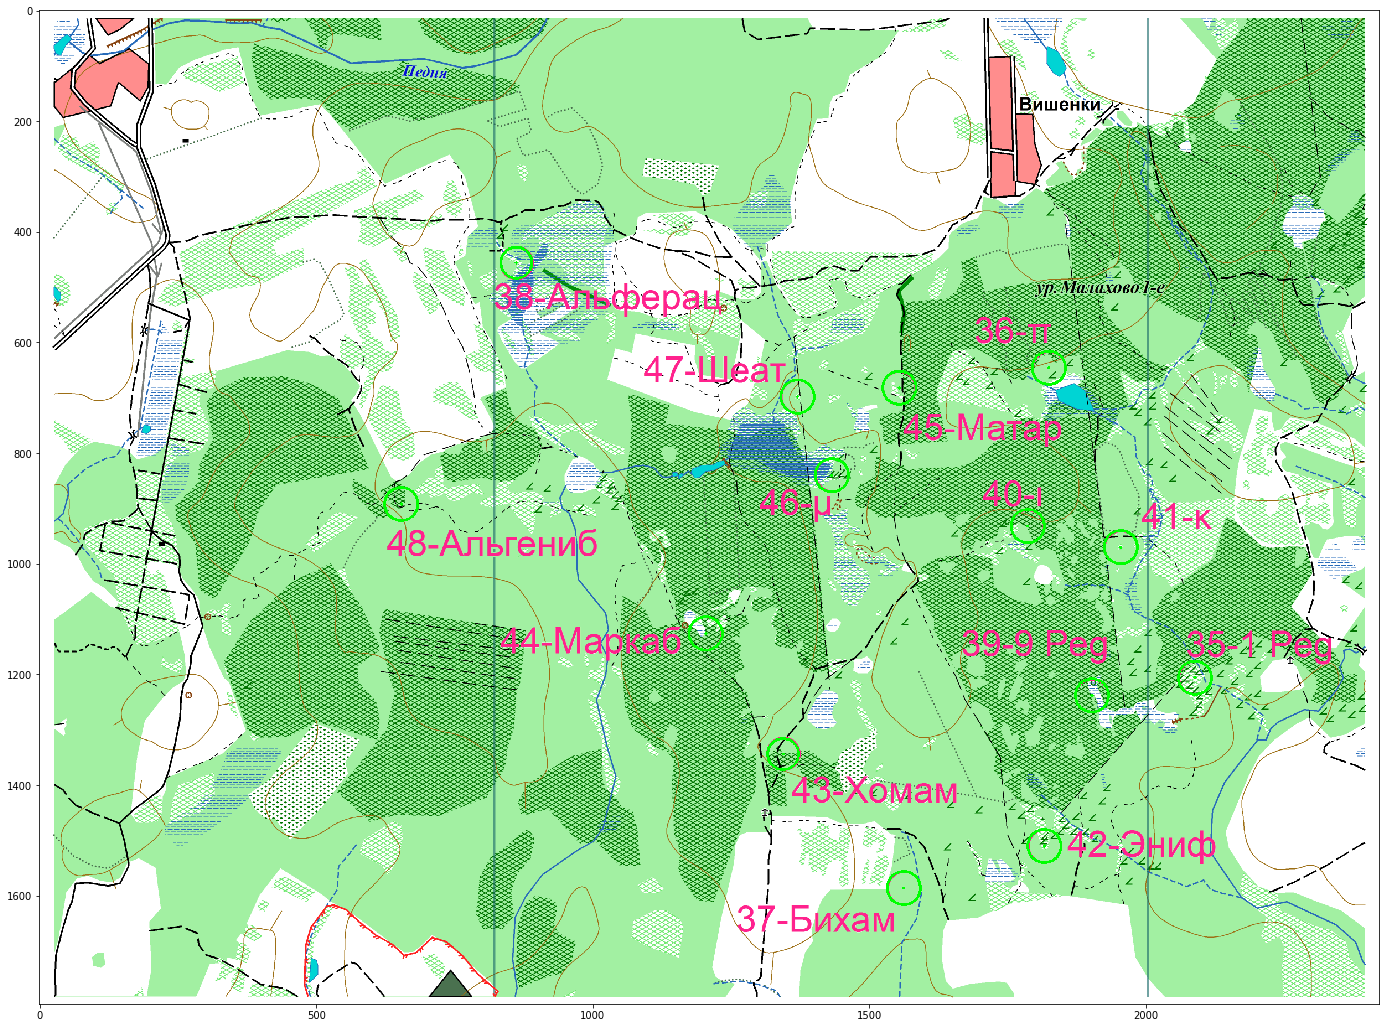

In [34]:
plt.figure(figsize=(24,24))
plt.imshow(img_for_plot,cmap='gray')
plt.show()